### Deep Learning Project

# Colorization of GrayScale Image using CNN model




In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model, load_model, Sequential, model_from_json
from tensorflow.keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# tf.compat.v1.disable_v2_behavior()

Getting Dataset


In [ ]:
!git clone https://{token}@github.com/regulusv/dl-proj.git

Cloning into 'dl-proj'...
remote: Enumerating objects: 22280, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 22280 (delta 7), reused 22 (delta 7), pack-reused 22258
Receiving objects: 100% (22280/22280), 527.58 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Checking out files: 100% (23821/23821), done.


## Read in Data
The dataset I am using is ~2000 classic paintings which we will remove the color from and attempt to teach a nearal network to recolorize them.

data source
https://www.kaggle.com/thedownhill/art-images-drawings-painting-sculpture-engraving


First, we would process with Dataset_portrait 

In [ ]:
TRAIN_PATH = '/content/dl-proj/dataset_art/training_set/painting/'

(360, 290, 3)

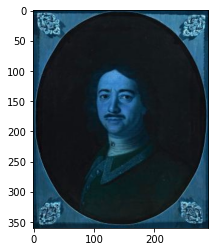

In [ ]:
# show image
img = cv2.imread(TRAIN_PATH+os.listdir(TRAIN_PATH)[0])
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (256, 256))
plt.imshow(img)
img.shape

In [ ]:
# data size
image_num = len([name for name in os.listdir(TRAIN_PATH)])
print("images count:", image_num)

images count: 2129


In [ ]:
# image dimentions 
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)

train_ids = next(os.walk(TRAIN_PATH))[2][:100]
print("how many train_id count? ", len(train_ids))
print(train_ids[:5])

how many train_id count?  100
['1167.jpg', '0876.jpg', '1451.jpg', '1713.jpg', '0758.jpg']


In [ ]:
# put images into np array, while some images are broken, we would skip them
X_train = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_train_arr = []
missing_count = 0
print("np.array shape: ", X_train.shape)

print('Getting training images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train_arr.append(img)
    except:
        # print("Img has problem: "+path)
        missing_count += 1

X_train = np.array(X_train_arr, dtype=np.uint8)
X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))
print("X_train shape: ", X_train.shape)

np.array shape:  (0, 256, 256, 3)
Getting training images ... 


100%|██████████| 100/100 [00:01<00:00, 67.59it/s]

Total missing: 5
X_train shape:  (95, 256, 256, 3)


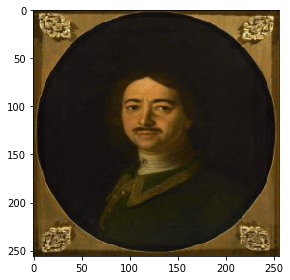

(256, 256, 3)

In [ ]:
# Display a sample image in X_train
imshow(X_train[0])
plt.show()
X_train[0].shape

Train/Test Set

Just getting a sample of 20 images to test the model when it is done.

In [ ]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=seed)

Resnet classifier

model is expected to have Combination of  of an autoencoder and resnet classifier. The best an autoencoder by itself is just shade everything in a brownish tone. The model uses an resnet classifier to give the neural network an "idea" of what things should be colored.

In [ ]:
# # Bring resnet
# import requests

# url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.7/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5'
# r = requests.get(url, allow_redirects=True)
# with open('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5', 'wb') as f:
#   f.write(r.content)

In [ ]:
# inception = InceptionResNetV2(weights=None, include_top=True)
# # print(type(inception))
# inception.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
# inception.graph = tf.compat.v1.get_default_graph()

Create the Model

Per work from Richard Zhang (2016), the model is a combination of an autoencoder and resnet classifier would have better results. The best an autoencoder by itself is just shade everything in a brownish tone. The model uses an resnet classifier to give the neural network an "idea" of what things should be colored. While as we tried, TF 2.0+ has some imcompatiblity while adopting InceptionResNetV2 within CNN here, we would leave adopting InceptionResNetV2 work in the future.

construct CNN model, referring paper:

![title](http://richzhang.github.io/colorization/resources/images/net_diagram.jpg)

Reference:

Zhang, Richard, Phillip Isola, and Alexei A. Efros. "Colorful image colorization." European conference on computer vision. Springer, Cham, 2016.

http://richzhang.github.io/colorization/

In [ ]:
def Colorize():
  #CNN model
  model = Sequential()

  #Input Layer
  model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

  #Hidden Layers
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(UpSampling2D((2, 2)))
  return model



In [ ]:
model = Colorize()
#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 512)      

Data Generator



There are two techniques to predict colored image from its gray scaled form:

Turn the RGB image into LAB image, then separate the L value and ab value from the image and then train the model to predict the ab value.
Turn the RGB image into LUV image, then separate the L value and UV value from the image and then train the model to predict the UV value.
Here we have used **LAB** value to colorize the image, where L stands for lightness, and a and b for the color spectra green–red and blue–yellow.

Convert the rgb values of the input image to the range of 0 to 1,

1.0/255 indicates that we are using a 24-bit RGB color space. It means that we are using numbers between 0–255 for each color channel.

img_lab = 1.0/225*img_lab resize the lightness channel to network input size.

The true color values range between -128 and 128. This is the default interval  in the LAB color space. By dividing them by 128, they too fall within the -1 to 1 interval.

In [ ]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(X_train, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)


Train the Model

In [ ]:
# Train model      
tensorboard = TensorBoard(log_dir="/output/beta_run")
trainedmodel = model.fit_generator(
    image_a_b_gen(batch_size), 
    callbacks=[tensorboard],
    epochs=30, 
    steps_per_epoch=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
30/30 [==============================] - 7s 206ms/step - loss: 0.3772 - accuracy: 0.4112
Epoch 2/30
30/30 [==============================] - 6s 200ms/step - loss: 0.0088 - accuracy: 0.8064
Epoch 3/30
30/30 [==============================] - 6s 202ms/step - loss: 0.0073 - accuracy: 0.8345
Epoch 4/30
30/30 [==============================] - 6s 203ms/step - loss: 0.0073 - accuracy: 0.8414
Epoch 5/30
30/30 [==============================] - 6s 206ms/step - loss: 0.0070 - accuracy: 0.8467
Epoch 6/30
30/30 [==============================] - 6s 201ms/step - loss: 0.0076 - accuracy: 0.8286
Epoch 7/30
30/30 [==============================] - 7s 239ms/step - loss: 0.0069 - accuracy: 0.8450
Epoch 8/30
30/30 [==============================] - 6s 202ms/step - loss: 0.0077 - accuracy: 0.8393
Epoch 9/30
30/30 [==============================] - 6s 206ms/step - loss: 0.0068 - accuracy: 0.8429
Epoch 10/30
30/30 [==============================] - 6s 204ms/step - loss: 0.0068 - accuracy: 0.8469

In [ ]:
# Summarize log for accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize log for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_color_art.h5")


In [ ]:
# Load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("model_color_art.h5")

In [ ]:
loaded_model.summary()


Sample the Results

In [ ]:
sample = X_test
color_me = gray2rgb(rgb2gray(sample))
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict(color_me)
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))

In [ ]:
plt.figure(figsize=(20, 6))
for i in range(10):
    # grayscale
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(X_test)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    # recolorization
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    # original
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(X_test[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

 Now we test model to colorize another type of pictures: landscape

In [ ]:
TRAIN_PATH = '/content/dl-proj/Dataset_landscape /color/'

In [ ]:
# show image
img = cv2.imread(TRAIN_PATH+os.listdir(TRAIN_PATH)[3])
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)
img.shape

In [ ]:
# put images into np array, while some images are broken, we would skip them
X_train = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_train_arr = []
missing_count = 0
print("np.array shape: ", X_train.shape)

print('Getting training images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train_arr.append(img)
    except:
        # print("Img has problem: "+path)
        missing_count += 1

X_train = np.array(X_train_arr, dtype=np.uint8)
X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))
print("X_train shape: ", X_train.shape)

In [ ]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=seed)

Samping results in picture: landscape

In [ ]:
def test_sample(X_test, model):
  sample = X_test
  color_me = gray2rgb(rgb2gray(sample))
  color_me = rgb2lab(color_me)[:,:,:,0]
  color_me = color_me.reshape(color_me.shape+(1,))

  output = model.predict(color_me)
  output = output * 128

  decoded_imgs = np.zeros((len(output),256, 256, 3))

  for i in range(len(output)):
      cur = np.zeros((256, 256, 3))
      cur[:,:,0] = color_me[i][:,:,0]
      cur[:,:,1:] = output[i]
      decoded_imgs[i] = lab2rgb(cur)
      cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))
  return decoded_imgs

In [ ]:
def plot_res(decoded_imgs, X_test):
  plt.figure(figsize=(20, 6))
  for i in range(10):
      # grayscale
      plt.subplot(3, 10, i + 1)
      plt.imshow(rgb2gray(X_test)[i].reshape(256, 256))
      plt.gray()
      plt.axis('off')
  
      # recolorization
      plt.subplot(3, 10, i + 1 +10)
      plt.imshow(decoded_imgs[i].reshape(256, 256,3))
      plt.axis('off')
      
      # original
      plt.subplot(3, 10, i + 1 + 20)
      plt.imshow(X_test[i].reshape(256, 256,3))
      plt.axis('off')
  
  plt.tight_layout()
  plt.show()

In [ ]:
decoded_imgs = test_sample(X_test, model)

In [ ]:
plot_res(decoded_imgs, X_test)

As we see, the predicted results are not acceptable,

So we. would retrain the CNN model using photos of landscape.

In [ ]:
# Re - train model      
model_landscape = Colorize()
#Compiling the CNN
model_landscape.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])
model_landscape.summary()

In [ ]:
batch_size = 10
tensorboard = TensorBoard(log_dir="/output/beta_run")
trainedmodel = model_landscape.fit_generator(
    image_a_b_gen(batch_size), 
    callbacks=[tensorboard],
    epochs=60, 
    steps_per_epoch=30)

In [ ]:
# Save model
model_landscape_json = model_landscape.to_json()
with open("model_landscape.json", "w") as json_file:
    json_file.write(model_landscape_json)
model_landscape.save_weights("model_color_landscape.h5")

# Load json and create model
json_file = open('model_landscape.json', 'r')
loaded_model_landscape_json = json_file.read()
json_file.close()
loaded_model_landscape = model_from_json(loaded_model_landscape_json)

# Load weights into new model
loaded_model_landscape.load_weights("model_color_landscape.h5")

In [ ]:
decoded_imgs = test_sample(X_test, model_landscape)

In [ ]:
plot_res(decoded_imgs, X_test)